# Generate synthetic lightcurves
Sample from parameters of all 78 Gaussian Processes to generate synthetic lightcurves.


Add uncorrelated noise by:
   - Define distribution over learned GP parameters
   - Create histogram of residuals (how many of each amplitude)
   - Define cutoff as 3 sigma
   - Add all cutoff 'tails' to create an 'average' noise distribution

In [1]:
# imports
import numpy as np
import csv
import matplotlib.pyplot as plt
from astropy.io import fits
import torch
import gpytorch
import matplotlib.pyplot as plt
import scipy
import linear_operator

from dipper.data_utils.utils import *
from dipper.model_utils.gp_model import *
from sklearn.mixture import GaussianMixture
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, FixedNoiseGaussianLikelihood
from gpytorch.kernels import Kernel, PeriodicKernel, RBFKernel, ScaleKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.constraints import Interval, Positive, GreaterThan, LessThan

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Load parameters and analyze distribution

In [19]:
# Load in all the data
mean_constants = []
outputscales = []
periodic_lengthscales = []
rescaled_periodic_lengthscales = []
periods = []
rbf_lengthscales = []
noises = []
num_high_residuals = []
mean_high_residuals = []
var_high_residuals = []

save_dir = '../../data/synthetic_params/'

with open(save_dir + 'gp_parameters.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        mean_constants.append(float(row[1]))
        outputscales.append(float(row[2]))
        periodic_lengthscales.append(float(row[3]))
        periods.append(float(row[4]))
        rescaled_periodic_lengthscales.append(float(row[3]) / float(row[4]))
        rbf_lengthscales.append(float(row[5]))
        noises.append(float(row[6]))
    
with open(save_dir + 'high_residuals.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        num_high_residuals.append(int(row[1]))
        if row[2] == '[]':
            row_2_float = np.array([0])
        else:
            row_2_float = np.array([float(x) for x in row[2].strip('[]').split()])
        mean_high_residuals.append(np.mean(row_2_float))
        var_high_residuals.append(np.var(row_2_float))
        
assert len(mean_constants) == len(outputscales) == len(periodic_lengthscales) == len(periods) == len(rbf_lengthscales) == len(noises) == len(num_high_residuals) == len(mean_high_residuals) == len(rescaled_periodic_lengthscales) == len(var_high_residuals)

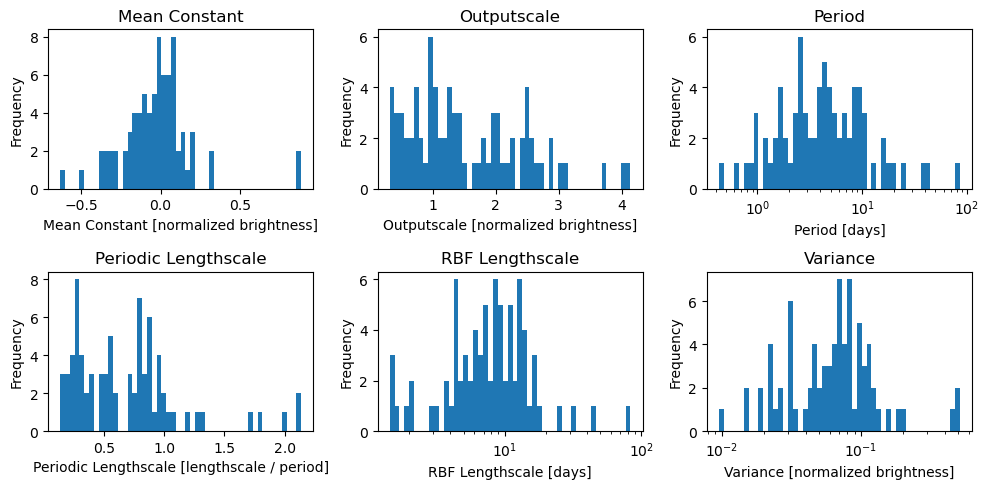

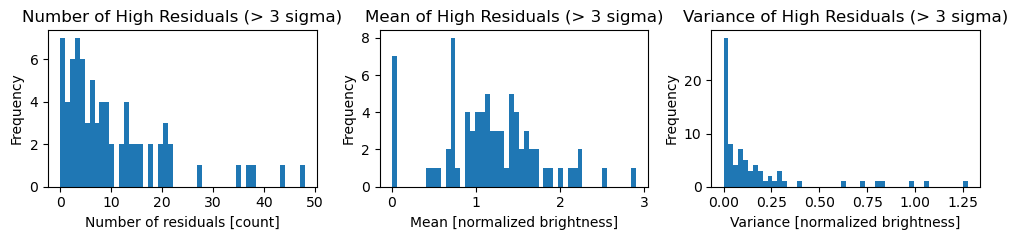

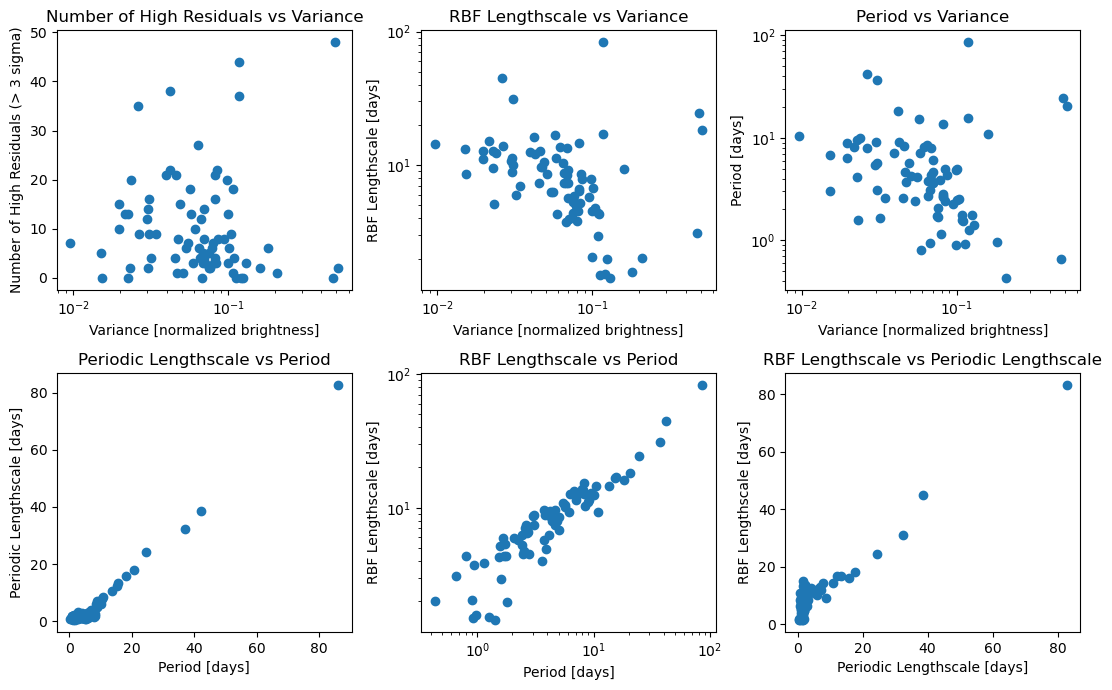

In [53]:
# Plot parameters all in one plot, separate subplots for each parameter
plt.figure(figsize=(10,5))
plt.subplot(2,3,1)
plt.hist(mean_constants, bins=50)
plt.xlabel("Mean Constant [normalized brightness]")
plt.ylabel("Frequency")
plt.title("Mean Constant")

plt.subplot(2,3,2)
plt.hist(outputscales, bins=50)
plt.xlabel("Outputscale [normalized brightness]")
plt.ylabel("Frequency")
plt.title("Outputscale")

plt.subplot(2,3,3)
plt.hist(periods, bins=np.logspace(np.log10(min(periods)), np.log10(max(periods)), 50))
plt.xscale('log')
plt.xlabel("Period [days]")
plt.ylabel("Frequency")
plt.title("Period")

plt.subplot(2,3,4)
plt.hist(rescaled_periodic_lengthscales, bins=50 )
plt.xlabel("Periodic Lengthscale [lengthscale / period]")
plt.ylabel("Frequency")
plt.title("Periodic Lengthscale")

plt.subplot(2,3,5)
plt.hist(rbf_lengthscales, bins=np.logspace(np.log10(min(rbf_lengthscales)), np.log10(max(rbf_lengthscales)), 50))
plt.xscale('log')
plt.xlabel("RBF Lengthscale [days]")
plt.ylabel("Frequency")
plt.title("RBF Lengthscale")

plt.subplot(2,3,6)
plt.hist(noises, bins=np.logspace(np.log10(min(noises)), np.log10(max(noises)), 50))
plt.xscale('log')
plt.xlabel("Variance [normalized brightness]")
plt.ylabel("Frequency")
plt.title("Variance")

plt.tight_layout()
plt.show()

# Plot histogram of high residuals
plt.figure(figsize=(10, 2.5))
plt.subplot(1,3,1)
plt.hist(num_high_residuals, bins=50)
plt.xlabel("Number of residuals [count]")
plt.ylabel("Frequency")
plt.title("Number of High Residuals (> 3 sigma)")

plt.subplot(1, 3, 2)
plt.hist(mean_high_residuals, bins=50)
plt.xlabel("Mean [normalized brightness]")
plt.ylabel("Frequency")
plt.title("Mean of High Residuals (> 3 sigma)")

plt.subplot(1, 3, 3)
plt.hist(var_high_residuals, bins=50)
plt.xlabel("Variance [normalized brightness]")
plt.ylabel("Frequency")
plt.title("Variance of High Residuals (> 3 sigma)")

plt.tight_layout()
plt.show()

# Plot cross-parameter distributions
plt.figure(figsize=(11, 7))

plt.subplot(2,3,1)
plt.scatter(noises, num_high_residuals)
plt.xscale('log')
plt.xlabel("Variance [normalized brightness]")
plt.ylabel("Number of High Residuals (> 3 sigma)")
plt.title("Number of High Residuals vs Variance")

plt.subplot(2,3,2)
plt.scatter(noises, rbf_lengthscales)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Variance [normalized brightness]")
plt.ylabel("RBF Lengthscale [days]")
plt.title("RBF Lengthscale vs Variance")

plt.subplot(2,3,3)
plt.scatter(noises, periods)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Variance [normalized brightness]")
plt.ylabel("Period [days]")
plt.title("Period vs Variance")

plt.subplot(2,3,4)
plt.scatter(periods, periodic_lengthscales)
plt.xlabel("Period [days]")
plt.ylabel("Periodic Lengthscale [days]")
plt.title("Periodic Lengthscale vs Period")

plt.subplot(2,3,5)
plt.scatter(periods, rbf_lengthscales)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Period [days]")
plt.ylabel("RBF Lengthscale [days]")
plt.title("RBF Lengthscale vs Period")

plt.subplot(2,3,6)
plt.scatter(periodic_lengthscales, rbf_lengthscales)
plt.xlabel("Periodic Lengthscale [days]")
plt.ylabel("RBF Lengthscale [days]")
plt.title("RBF Lengthscale vs Periodic Lengthscale")

plt.tight_layout()
plt.show()

### Read parameters and generate a sample from distribution over parameters

In [54]:
# Function to fit a distribution and return parameters
def fit_best_distribution(
        data, 
        num_bins=100,
        log=False,
        dist_names=None,
        plot=False
    ):

    if dist_names is None:
        dist_names = ['norm', 'expon', 'lognorm', 'gamma', 'beta', 'uniform']
    
    best_fit_name = None
    best_fit_params = None
    best_sse = np.inf  # Smallest sum of squared errors

    # Histogram for calculating density
    if log:
        bins = np.logspace(np.log10(min(data)), np.log10(max(data)), num_bins)
    else:
        bins = num_bins

    hist, bin_edges = np.histogram(data, bins=bins, density=True)    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoints of bins

    # Try fitting each distribution
    for dist_name in dist_names:
        try:
            dist = getattr(scipy.stats, dist_name)
            params = dist.fit(data)  # Fit the distribution
            pdf = dist.pdf(bin_centers, *params)
            sse = np.sum((hist - pdf) ** 2)
            
            if sse < best_sse:
                best_fit_name = dist_name
                best_fit_params = params
                best_sse = sse
        except Exception as e:
            print(f"Error fitting {dist_name}: {e}")

    if plot:
        plt.figure(figsize=(10,5))
        plt.hist(data, bins=bins, density=True, alpha=0.6)
        x = np.linspace(min(data), max(data), 1000)
        pdf = getattr(scipy.stats, best_fit_name).pdf(x, *best_fit_params)
        plt.plot(x, pdf, 'r', lw=2)
        plt.ylim(0, min(max(pdf), 30))
        plt.title(f"Best fit distribution: {best_fit_name}")
        plt.show()
    
    return best_fit_name, best_fit_params

# Function to sample from fitted distributions
def sample_from_distributions(
        data_dict,
        distribution_dict = None,
        ):
    
    samples = {}
    for key, values in data_dict.items():
        # Fit the distribution to the parameter
        if distribution_dict is not None and key in distribution_dict:
            dist_name, params = distribution_dict[key]
            dist = getattr(scipy.stats, dist_name)
        else:
            dist_name, params = fit_best_distribution(values)
            dist = getattr(scipy.stats, dist_name)
        
        # Sample new values
        samples[key] = dist.rvs(*params, size=1)
    return samples

### Fit distributions and write to files

Fitting distribution for mean_constants


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


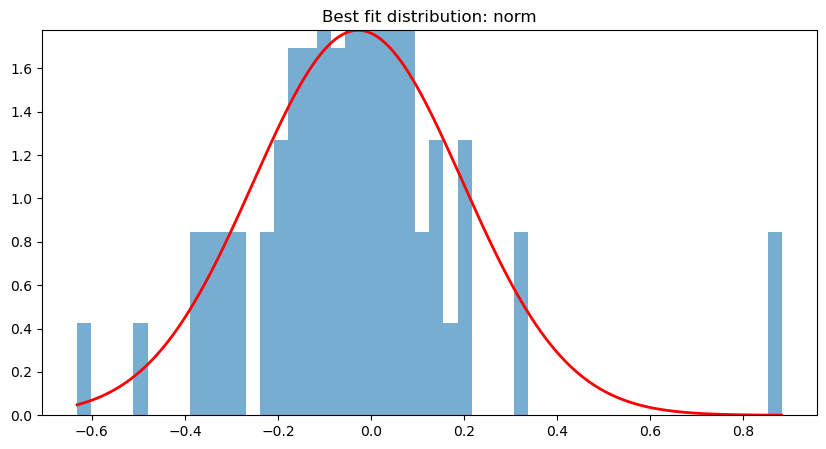

Fitting distribution for outputscales


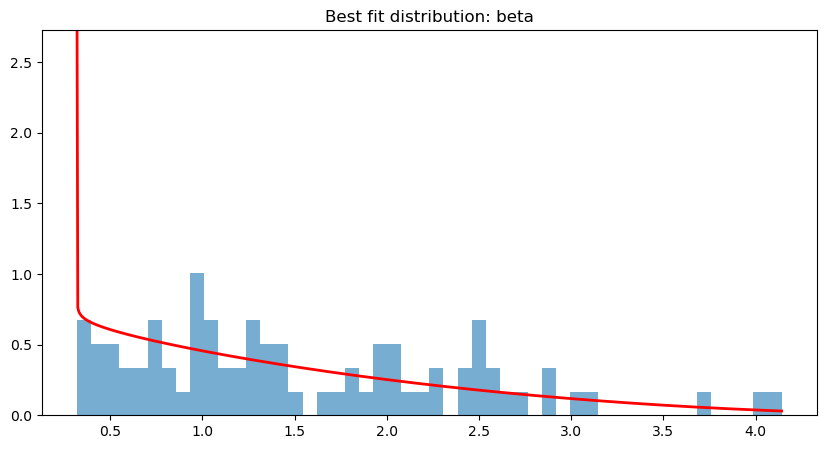

Fitting distribution for periodic_lengthscales


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:721: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


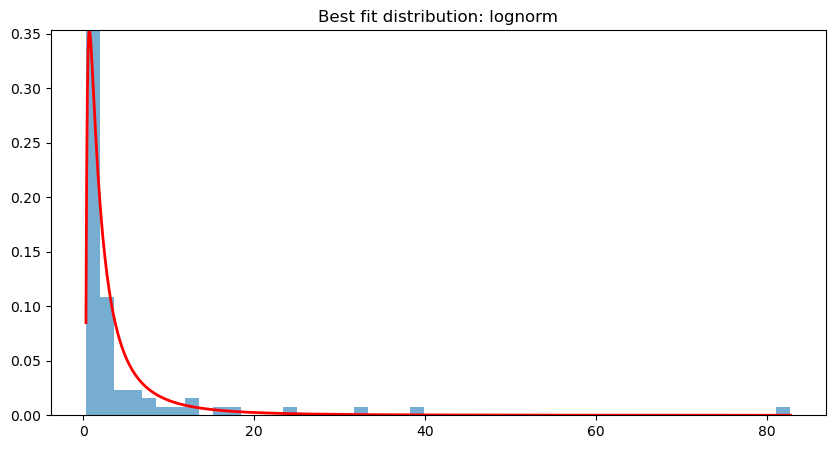

Fitting distribution for periods


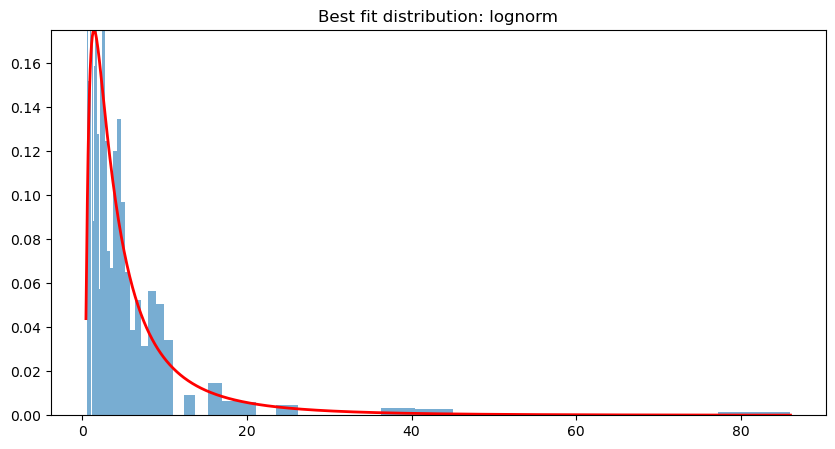

Fitting distribution for rbf_lengthscales


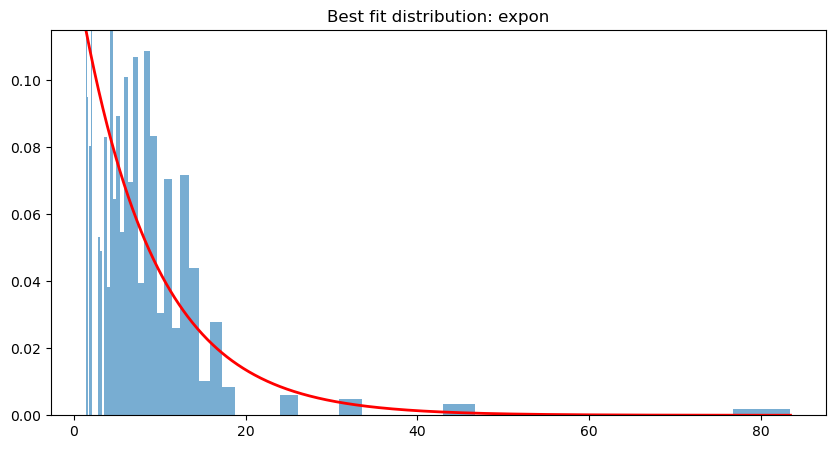

Fitting distribution for noises


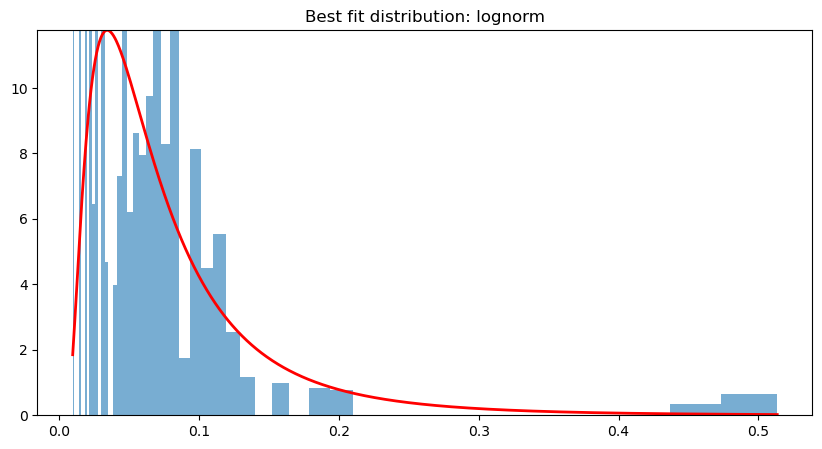

Fitting distribution for num_high_residuals


/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6554: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


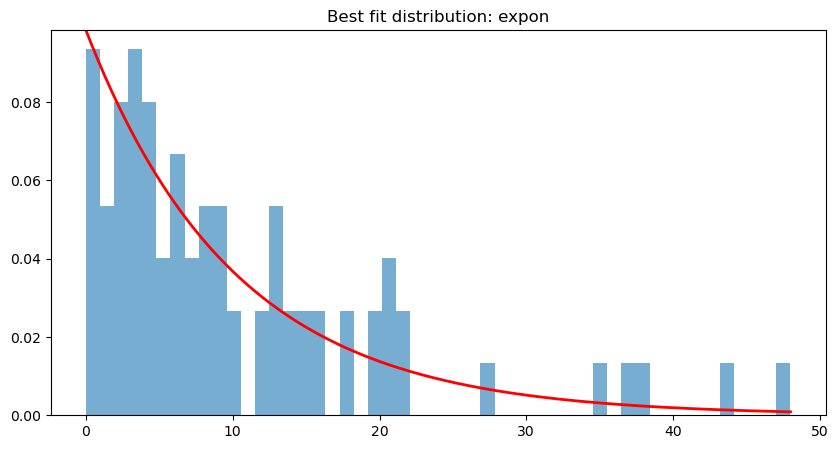

Fitting distribution for mean_high_residuals


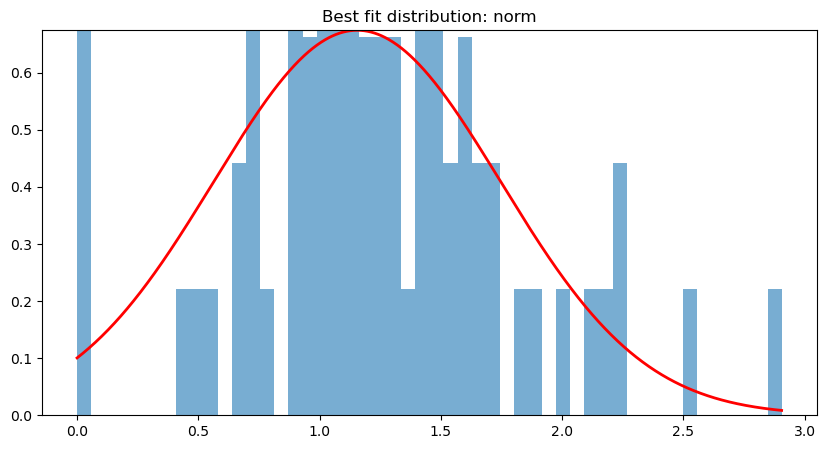

Fitting distribution for var_high_residuals


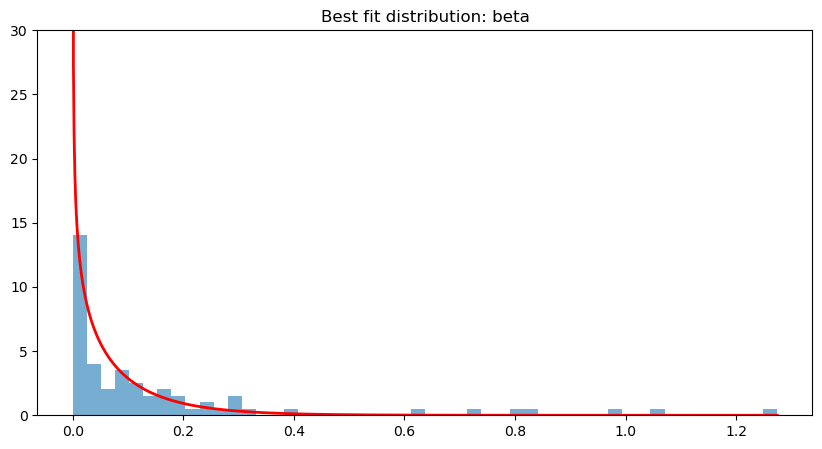

{'mean_constants': ('norm', (-0.027818446740126, 0.2246970458934941)), 'outputscales': ('beta', (0.9601195290774782, 3.198904762321293, 0.3201384544372558, 5.164427502590369)), 'periodic_lengthscales': ('lognorm', (1.193690195220042, 0.26812697976315913, 1.928942426393549)), 'periods': ('lognorm', (1.0796637837369463, 0.23472118758765498, 3.7817816770201453)), 'rbf_lengthscales': ('expon', (1.436642050743103, 8.697111817506643)), 'noises': ('lognorm', (0.7859383092135493, 0.002592423091687254, 0.05877363407778504)), 'num_high_residuals': ('expon', (0.0, 10.166666666666666)), 'mean_high_residuals': ('norm', (1.154785259724531, 0.591756426517452)), 'var_high_residuals': ('beta', (0.6907309174587515, 116.19464339129175, -1.7835229040668747e-30, 12.684570282098136))}


In [55]:
# Read GP parameters and high_residuals from files
mean_constants = []
outputscales = []
periodic_lengthscales = []
periods = []
rbf_lengthscales = []
noises = []
num_high_residuals = []
mean_high_residuals = []
var_high_residuals = []

save_dir = '../../data/synthetic_params/'

with open(save_dir + 'gp_parameters.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        mean_constants.append(float(row[1]))
        outputscales.append(float(row[2]))
        periodic_lengthscales.append(float(row[3]))
        periods.append(float(row[4]))
        rbf_lengthscales.append(float(row[5]))
        noises.append(float(row[6]))
    
with open(save_dir + 'high_residuals.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        num_high_residuals.append(int(row[1]))
        
        if row[2] == '[]':
            row_2_float = np.array([0])
        else:
            row_2_float = np.array([float(x) for x in row[2].strip('[]').split()])

        mean_high_residuals.append(np.mean(row_2_float))
        var_high_residuals.append(np.var(row_2_float))

# Write parameters and their distributions to a file
parameters = {
    'mean_constants': mean_constants,
    'outputscales': outputscales,
    'periodic_lengthscales': periodic_lengthscales,
    'periods': periods,
    'rbf_lengthscales': rbf_lengthscales,
    'noises': noises,
    'num_high_residuals': num_high_residuals,
    'mean_high_residuals': mean_high_residuals,
    'var_high_residuals': var_high_residuals
}

dists = {}
for key, values in parameters.items():
    # assign log indexing for some parameters
    if key in ['rbf_lengthscales', 'periods', 'noises']:
        log = True
    else:
        log = False
        
    # Fit the distribution
    print(f"Fitting distribution for {key}")
    dist_name, params = fit_best_distribution(
        values, 
        num_bins=50, 
        log=log, 
        plot=True
    )
    dists[key] = (dist_name, params)

print(dists)
with open(save_dir + 'fitted_distributions.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['parameter', 'distribution', 'params'])
    for key, value in dists.items():
        writer.writerow([key, value[0], value[1]])

### Load distributions from file and generate a sample

In [56]:
# Read GP parameters and high_residuals from files
mean_constants = []
outputscales = []
periodic_lengthscales = []
periods = []
rbf_lengthscales = []
noises = []
num_high_residuals = []
mean_high_residuals = []
var_high_residuals = []

save_dir = '../../data/synthetic_params/'

with open(save_dir + 'gp_parameters.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        mean_constants.append(float(row[1]))
        outputscales.append(float(row[2]))
        periodic_lengthscales.append(float(row[3]))
        periods.append(float(row[4]))
        rbf_lengthscales.append(float(row[5]))
        noises.append(float(row[6]))
    
with open(save_dir + 'high_residuals.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        num_high_residuals.append(int(row[1]))
        
        if row[2] == '[]':
            row_2_float = np.array([0])
        else:
            row_2_float = np.array([float(x) for x in row[2].strip('[]').split()])

        mean_high_residuals.append(np.mean(row_2_float))
        var_high_residuals.append(np.var(row_2_float))


data_dict = {
    'mean_constants': mean_constants,
    'outputscales': outputscales,
    'periodic_lengthscales': periodic_lengthscales,
    'periods': periods,
    'rbf_lengthscales': rbf_lengthscales,
    'noises': noises,
    'num_high_residuals': num_high_residuals,
    'mean_high_residuals': mean_high_residuals,
    'var_high_residuals': var_high_residuals
}

# Load distributions from file
load_dists = {}
with open(save_dir + 'fitted_distributions.csv') as file:
    reader = csv.reader(file)
    for row in reader:
        if row[0] == 'parameter':
            continue

        key = row[0]
        dist_name = row[1]
        params = tuple(map(float, row[2].strip('()').split(',')))

        load_dists[key] = (dist_name, params)

# Fit distributions and sample
sampled_data = sample_from_distributions(
    data_dict,
    load_dists
)

print(sampled_data)


{'mean_constants': array([-0.11098524]), 'outputscales': array([1.16123665]), 'periodic_lengthscales': array([2.45526581]), 'periods': array([3.99772461]), 'rbf_lengthscales': array([4.72702274]), 'noises': array([0.04241747]), 'num_high_residuals': array([7.63192692]), 'mean_high_residuals': array([1.57313888]), 'var_high_residuals': array([0.05708539])}


### Generate lightcurves from the sample

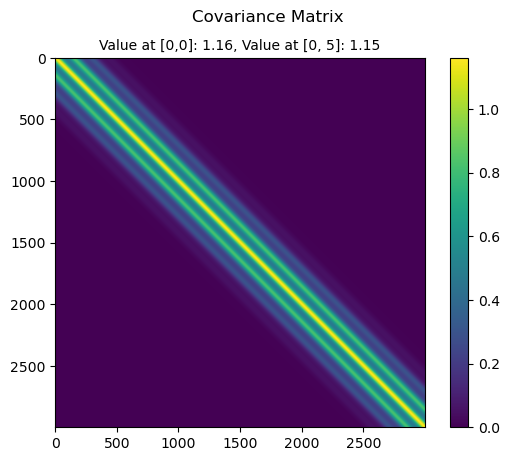

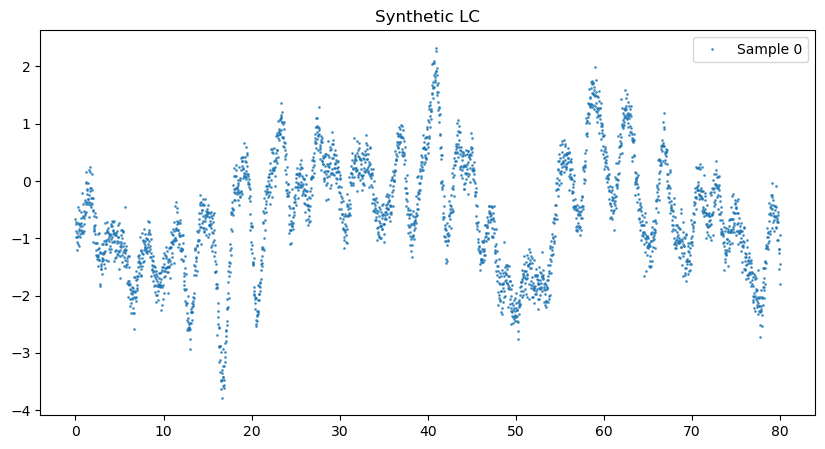

In [57]:
num_timesteps=3000
num_samples=1

# Define timesteps, y as Gaussian noise, and noise
x_sample = torch.linspace(0, 80, num_timesteps).to(device)

# Initialize kernel and mean with the learned parameters
kernel = ScaleKernel(QuasiPeriodicKernel())
kernel.outputscale = sampled_data["outputscales"]
kernel.base_kernel.periodic_kernel.period_length = sampled_data["periods"]
kernel.base_kernel.periodic_kernel.lengthscale = sampled_data["periodic_lengthscales"]
kernel.base_kernel.rbf_kernel.lengthscale = sampled_data["rbf_lengthscales"]

mean = ConstantMean()
mean.constant = sampled_data["mean_constants"]

noise_std = np.sqrt(sampled_data["noises"])

# Sample from the MultivariateNormal defined by the learned kernel and mean
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    mean_x = mean(x_sample).cpu()
    covar_x = kernel(x_sample).cpu()
    predictions = MultivariateNormal(mean_x, covar_x)

    samples = predictions.sample(sample_shape=torch.Size([num_samples])) # Only sample 1 lightcurve; can increase this value

# Add uncorrelated gaussian noise with noise_std
noisy_samples = samples.cpu().numpy()
noisy_samples += np.random.normal(0, noise_std, size=noisy_samples.shape)

# Plot covariance matrix
plt.figure()
plt.imshow(predictions.covariance_matrix.cpu().numpy())
plt.colorbar()
plt.suptitle("Covariance Matrix")
plt.title(f"Value at [0,0]: {predictions.covariance_matrix.cpu().numpy()[0,0]:.2f}, Value at [0, 5]: {predictions.covariance_matrix.cpu().numpy()[0,5]:.2f}", fontsize=10)
plt.show()

# Convert to numpy for further processing
x = x_sample.detach().cpu().numpy()
samples = samples.detach().cpu().numpy()

# Sample num_residuals from a normal distribution with mean mean_residuals and std of sqrt(var_residuals)
# for i in range(num_samples):
#     num_high_residuals = int(sampled_data["num_high_residuals"])
#     residuals = np.random.normal(loc=sampled_data["mean_high_residuals"], scale=np.sqrt(sampled_data["var_high_residuals"]), size=num_high_residuals)

#     # Randomly flip signs with 33% probability
#     signs = np.random.choice([1, 1, -1], size=num_high_residuals)
#     residuals *= signs

#     high_residual_indices = np.random.choice(len(x), num_high_residuals, replace=False)
#     for idx_res, idx_sample in enumerate(high_residual_indices):
#         samples[i][idx_sample] += residuals[idx_res]

plt.figure(figsize=(10,5))
for i in range(num_samples):
    plt.plot(x, samples[i], '.', ms=2, alpha=0.7, label=f'Sample {i}')
plt.legend()
plt.title("Synthetic LC")
plt.show()

### Generate many samples from different lightcurves


 {'mean_constants': array([-0.08331182]), 'outputscales': array([0.84185325]), 'periodic_lengthscales': array([7.06542249]), 'periods': array([4.50135126]), 'rbf_lengthscales': array([3.14628565]), 'noises': array([0.09032296]), 'num_high_residuals': array([0.21019477]), 'mean_high_residuals': array([0.65049527]), 'var_high_residuals': array([0.10083243])}


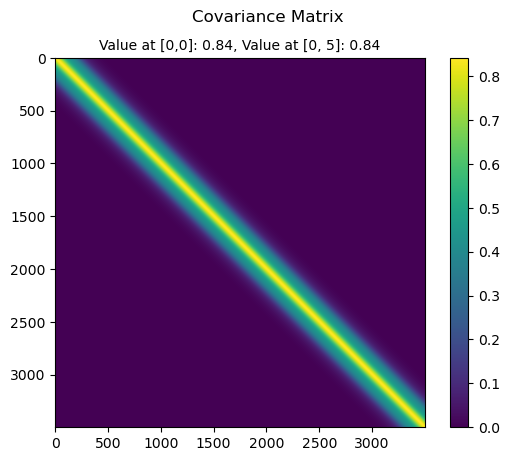


 {'mean_constants': array([0.32553457]), 'outputscales': array([0.98672604]), 'periodic_lengthscales': array([1.47958743]), 'periods': array([1.14761874]), 'rbf_lengthscales': array([9.79795925]), 'noises': array([0.01306674]), 'num_high_residuals': array([8.68976217]), 'mean_high_residuals': array([0.45205467]), 'var_high_residuals': array([0.00617705])}


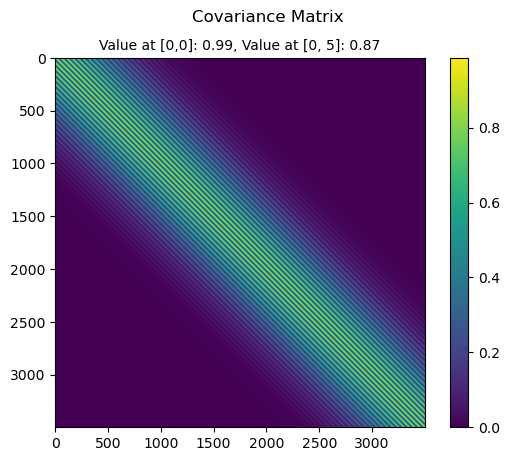


 {'mean_constants': array([-0.08031858]), 'outputscales': array([3.14395426]), 'periodic_lengthscales': array([3.67259656]), 'periods': array([2.4800711]), 'rbf_lengthscales': array([14.05796641]), 'noises': array([0.11832313]), 'num_high_residuals': array([25.46791028]), 'mean_high_residuals': array([1.2203401]), 'var_high_residuals': array([0.08859175])}


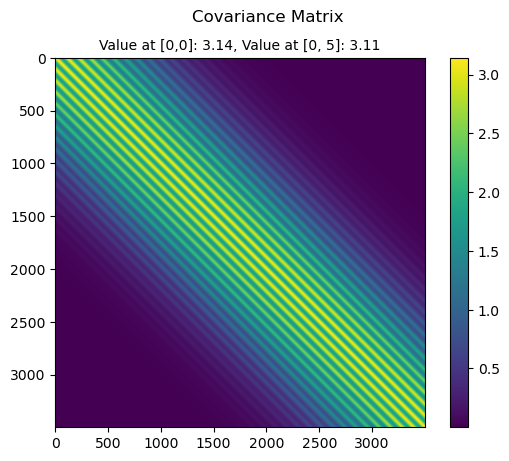

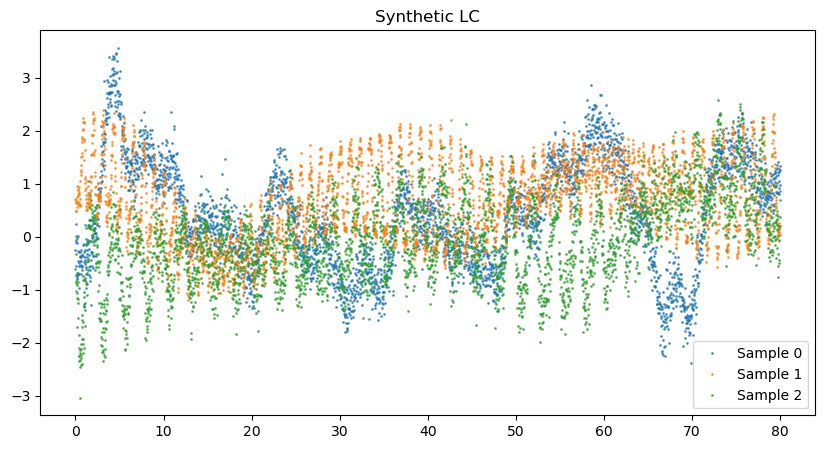

In [60]:
x_sample = torch.linspace(0, 80, 3500).to(device)
num_samples = 3
lc_samples = []

data_dict = {
    'mean_constants': mean_constants,
    'outputscales': outputscales,
    'periodic_lengthscales': periodic_lengthscales,
    'periods': periods,
    'rbf_lengthscales': rbf_lengthscales,
    'noises': noises,
    'num_high_residuals': num_high_residuals,
    'mean_high_residuals': mean_high_residuals,
    'var_high_residuals': var_high_residuals
}

# Load distributions from file
load_dists = {}
with open(save_dir + 'fitted_distributions.csv') as file:
    reader = csv.reader(file)
    for row in reader:
        if row[0] == 'parameter':
            continue

        key = row[0]
        dist_name = row[1]
        params = tuple(map(float, row[2].strip('()').split(',')))

        load_dists[key] = (dist_name, params)

for i in range(num_samples):
    # Fit distributions and sample
    sampled_data = sample_from_distributions(
        data_dict,
        load_dists
    )

    print('\n', sampled_data)

    # Initialize kernel and mean with the learned parameters
    kernel = ScaleKernel(QuasiPeriodicKernel())
    kernel.outputscale = sampled_data["outputscales"]
    kernel.base_kernel.periodic_kernel.period_length = sampled_data["periods"]
    kernel.base_kernel.periodic_kernel.lengthscale = sampled_data["periodic_lengthscales"]
    kernel.base_kernel.rbf_kernel.lengthscale = sampled_data["rbf_lengthscales"]

    mean = ConstantMean()
    mean.constant = sampled_data["mean_constants"]

    noise_std = np.sqrt(sampled_data["noises"])

    # Sample from the MultivariateNormal defined by the learned kernel and mean
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        mean_x = mean(x_sample).cpu()
        covar_x = kernel(x_sample).cpu()
        predictions = MultivariateNormal(mean_x, covar_x)

        samples = predictions.sample(sample_shape=torch.Size([1])) # Only sample 1 lightcurve; can increase this value

    # Add uncorrelated gaussian noise with noise_std
    noisy_samples = samples.cpu().numpy()[0]
    noisy_samples += np.random.normal(0, noise_std, size=noisy_samples.shape)

    # Plot covariance matrix
    plt.figure()
    plt.imshow(predictions.covariance_matrix.cpu().numpy())
    plt.colorbar()
    plt.suptitle("Covariance Matrix")
    plt.title(f"Value at [0,0]: {predictions.covariance_matrix.cpu().numpy()[0,0]:.2f}, Value at [0, 5]: {predictions.covariance_matrix.cpu().numpy()[0,5]:.2f}", fontsize=10)
    plt.show()

    # Convert to numpy for further processing
    x = x_sample.detach().cpu().numpy()
    samples = samples.detach().cpu().numpy()[0]
    
    # # Sample num_residuals from a normal distribution with mean mean_residuals and std of sqrt(var_residuals)
    # num_high_residuals = int(sampled_data["num_high_residuals"])
    # residuals = np.random.normal(loc=sampled_data["mean_high_residuals"], scale=np.sqrt(sampled_data["var_high_residuals"]), size=num_high_residuals)

    # # Randomly flip signs with 33% probability
    # signs = np.random.choice([1, 1, -1], size=num_high_residuals)
    # residuals *= signs

    # high_residual_indices = np.random.choice(len(x), num_high_residuals, replace=False)
    # for idx_res, idx_sample in enumerate(high_residual_indices):
    #     samples[idx_sample] += residuals[idx_res]

    lc_samples.append(samples)

plt.figure(figsize=(10,5))
for i in range(num_samples):
    plt.plot(x, lc_samples[i], '.', ms=2, alpha=0.7, label=f'Sample {i}')
plt.legend()
plt.title("Synthetic LC")
plt.show()